In [1]:
!pip install tensorflowjs

     |████████████████████████████████| 64 kB 1.8 MB/s 


In [5]:
import tensorflow as tf
import zipfile
import glob
from sklearn.model_selection import train_test_split
import os as os
import shutil
from shutil import copyfile
import random

In [6]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2021-08-17 06:05:34--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.29.84.109, 2600:1408:c400:18b::e59, 2600:1408:c400:191::e59
Connecting to download.microsoft.com (download.microsoft.com)|184.29.84.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   152MB/s    in 5.0s    

2021-08-17 06:05:40 (157 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [7]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [8]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [9]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [10]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


In [13]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"

In [25]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True,
                                                                  validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [28]:
train_images = train_generator.flow_from_directory(TRAINING_DIR,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(224, 224))

val_images = train_generator.flow_from_directory(VALIDATION_DIR,
                                                  batch_size=250,
                                                  class_mode='binary',
                                                  target_size=(224, 224))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [33]:
model = tf.keras.Sequential([
                             
      tf.keras.layers.Conv2D(16,(3,3),(2,2),activation="relu",input_shape=(224,224,3)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D((2,2),strides=2),
      tf.keras.layers.Dropout(.25),

      tf.keras.layers.Conv2D(32,(3,3),(2,2),activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D((2,2),strides=2),
      tf.keras.layers.Dropout(.25),

      tf.keras.layers.Conv2D(64,(3,3),(2,2),activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D((2,2),strides=2),
      tf.keras.layers.Dropout(.25),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(1, activation='sigmoid')

])


In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 111, 111, 16)      448       
_________________________________________________________________
batch_normalization_6 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 55, 55, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 32)        4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)       

In [38]:
history = model.fit(
    train_images,
    epochs=15,
    steps_per_epoch=90,
    validation_data=val_images,
    validation_steps=6
)

Epoch 1/15
78/90 [=========================>....] - ETA: 34s - loss: 0.7691 - accuracy: 0.5951

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

90/90 [==============================] - 272s 3s/step - loss: 0.7496 - accuracy: 0.6029 - val_loss: 0.8951 - val_accuracy: 0.4940
Epoch 2/15
90/90 [==============================] - 273s 3s/step - loss: 0.5927 - accuracy: 0.6758 - val_loss: 0.9426 - val_accuracy: 0.5167
Epoch 3/15
90/90 [==============================] - 269s 3s/step - loss: 0.5570 - accuracy: 0.7120 - val_loss: 1.4155 - val_accuracy: 0.4927
Epoch 4/15
90/90 [==============================] - 278s 3s/step - loss: 0.5276 - accuracy: 0.7346 - val_loss: 0.9988 - val_accuracy: 0.5653
Epoch 5/15
90/90 [==============================] - 272s 3s/step - loss: 0.5010 - accuracy: 0.7533 - val_loss: 0.6613 - val_accuracy: 0.6947
Epoch 6/15
90/90 [==============================] - 282s 3s/step - loss: 0.4818 - accuracy: 0.7671 - val_loss: 0.9497 - val_accuracy: 0.6040
Epoch 7/15
90/90 [==============================] - 274s 3s/step - loss: 0.4651 - accuracy: 0.7747 - val_loss: 0.4450 - val_accuracy: 0.7933
Epoch 8/15
90/90 [======

In [45]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
model.save("cat_vs_dog_tf.h5")

<Figure size 432x288 with 0 Axes>

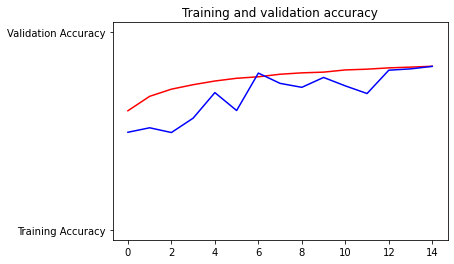

<Figure size 432x288 with 0 Axes>

In [47]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

<Figure size 432x288 with 0 Axes>

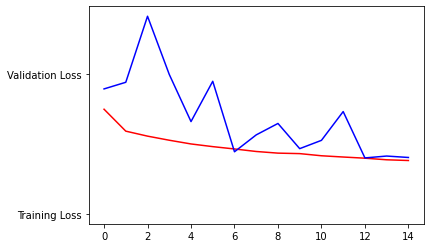

<Figure size 432x288 with 0 Axes>

In [48]:
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


In [58]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving 8.jpg to 8.jpg
[0.]
8.jpg is a cat


In [55]:
import tensorflowjs as tfjs

In [56]:
tfjs.converters.save_keras_model(model,"cat_vs_dog_tfjs")